<a href="https://colab.research.google.com/github/zhestyatsky/mipt-opt-project/blob/master/src/params_dependency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/zhestyatsky/mipt-opt-project.git
import sys
sys.path.append('/content/mipt-opt-project/src')

fatal: destination path 'mipt-opt-project' already exists and is not an empty directory.


In [0]:
import copy
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import utils
from spider_boost import spider_boost
from natasha import natasha_15, natasha_2

In [8]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = utils.DatasetWrapper(train_dataset)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class CustomNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomNN, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, 32)
        self.conv2 = torch.nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        outputs = torch.sigmoid(self.conv2(x))
        return outputs

In [0]:
loss = torch.nn.CrossEntropyLoss()
nonconv_reg = utils.regularizer
conv_reg = utils.param_norm

model = CustomNN(784, 10)

In [0]:
LR = [1e-5, 1e-4, 1e-3, 1e-2]
BS = [250, 500, 1000, 2000]

n_epochs = 100

sb_models = dict()
sb_losses = dict()

In [0]:
from itertools import product
for lr, batch_size in product(LR, BS):
    sb_models[(lr, batch_size)] = copy.deepcopy(model).cuda()

In [0]:
for learning_rate, batch_size in product(LR, BS):
    sb_losses[(learning_rate, batch_size)] = spider_boost(train_dataset, batch_size, sb_models[(learning_rate, batch_size)], loss, nonconv_reg, learning_rate, n_epochs)

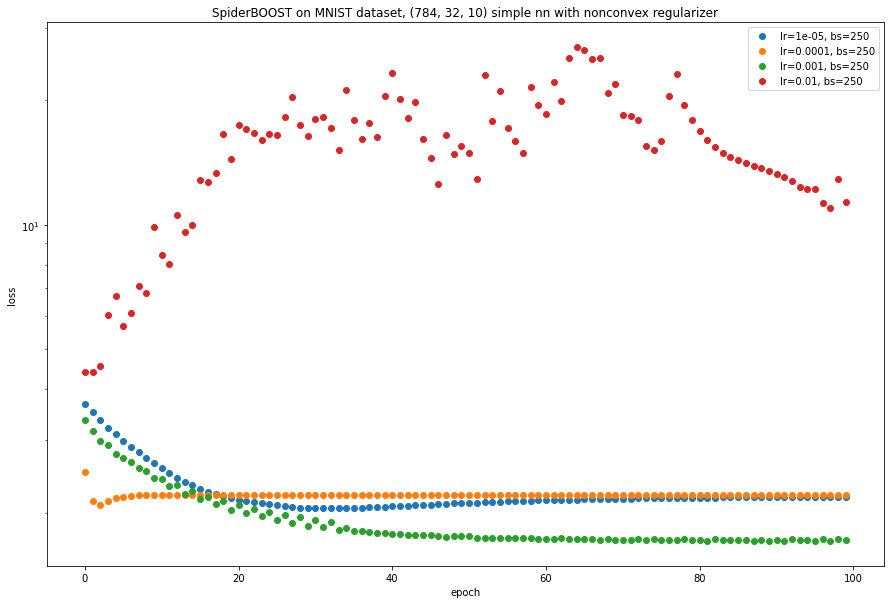

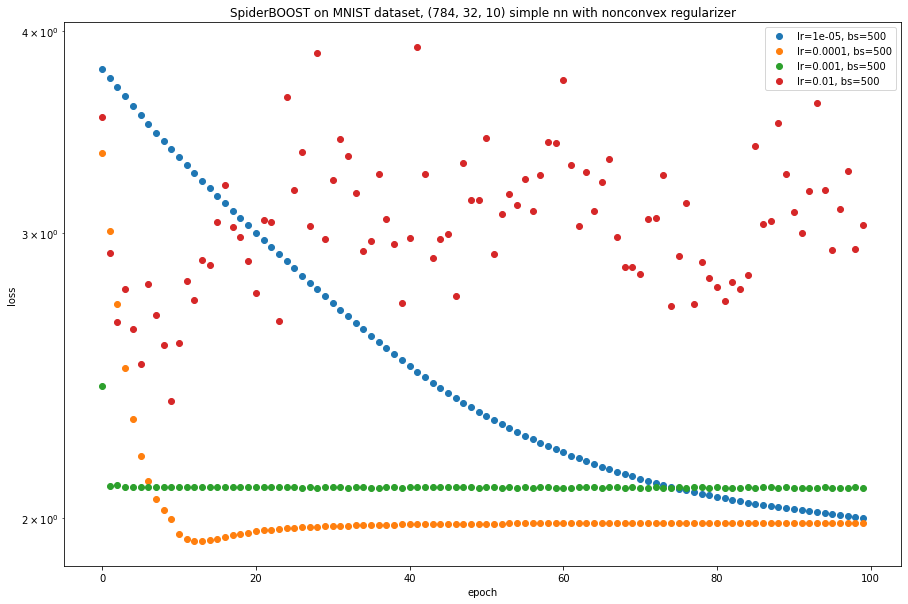

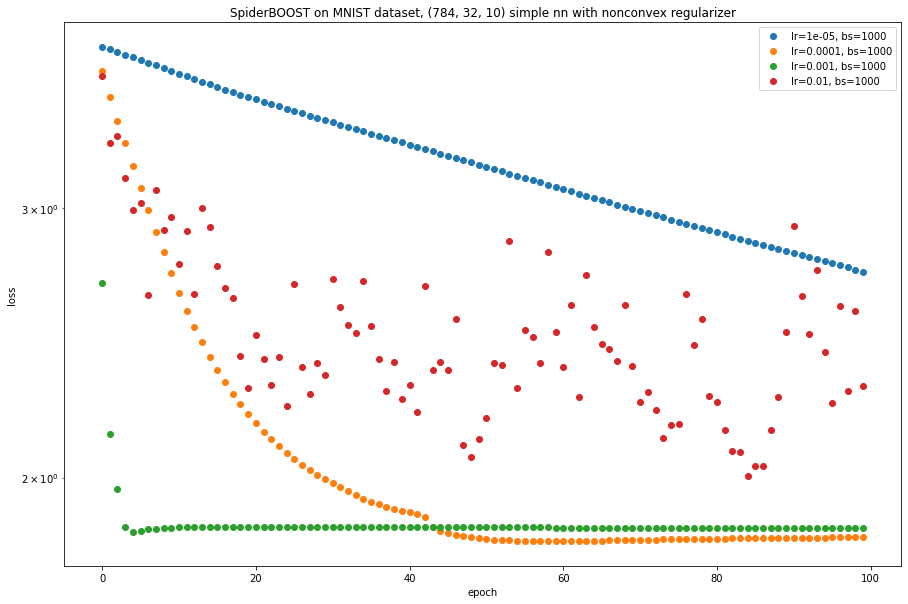

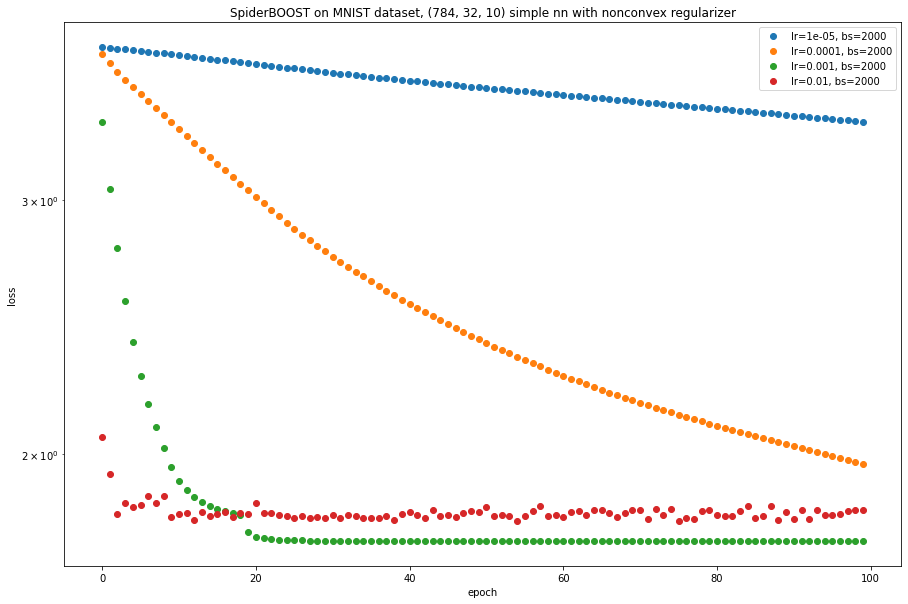

In [16]:
for bs in BS:
    plt.figure(figsize = (15,10))
    plt.title("SpiderBOOST on MNIST dataset, (784, 32, 10) simple nn with nonconvex regularizer")
    for lr in LR:
        plt.plot(sb_losses[lr, bs], 'o', label="lr="+str(lr)+", bs="+str(bs))
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.semilogy()
    # plt.savefig("../img/sp_bs_"+str(bs)+".png")


In [0]:
LR = [1e-5, 1e-4]
BS = [250, 1000, 2000]
Sigmas = [0, 25, 50, 100, 200]

n_epochs = 100

n15_models = dict()
n15_losses = dict()

In [0]:
for lr, bs, s in product(LR, BS, Sigmas):
    n15_models[(lr, bs, s)] = copy.deepcopy(model).cuda()

In [0]:
for lr, bs, s in product(LR, BS, Sigmas):
    n15_losses[(lr, bs, s)] = natasha_15(train_dataset, bs, n15_models[(lr, bs, s)], loss, None, lr, n_epochs, sigma=s)

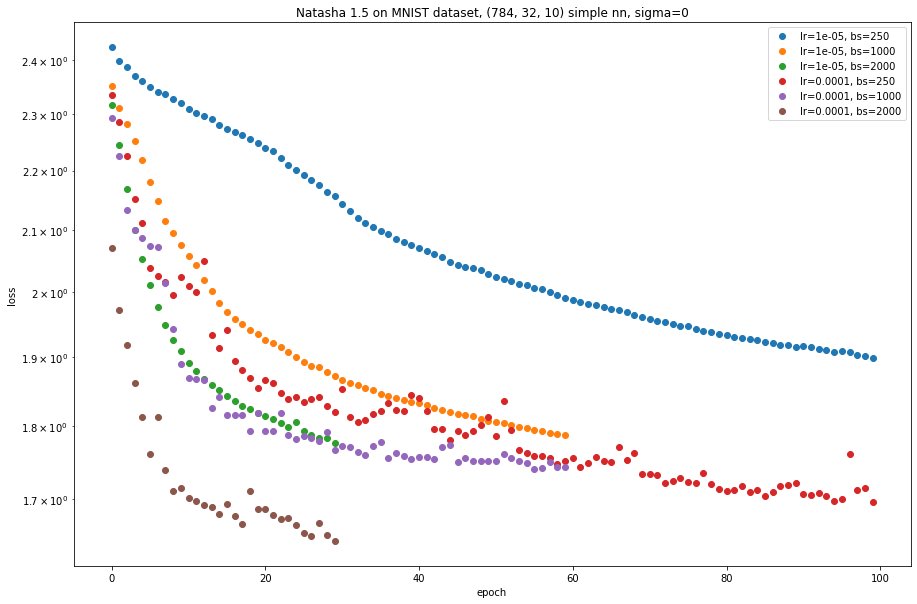

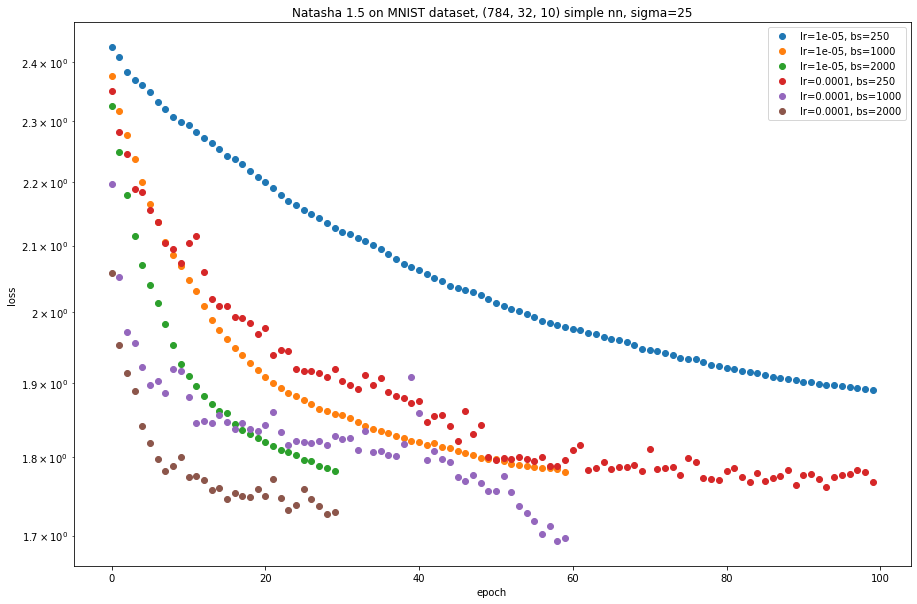

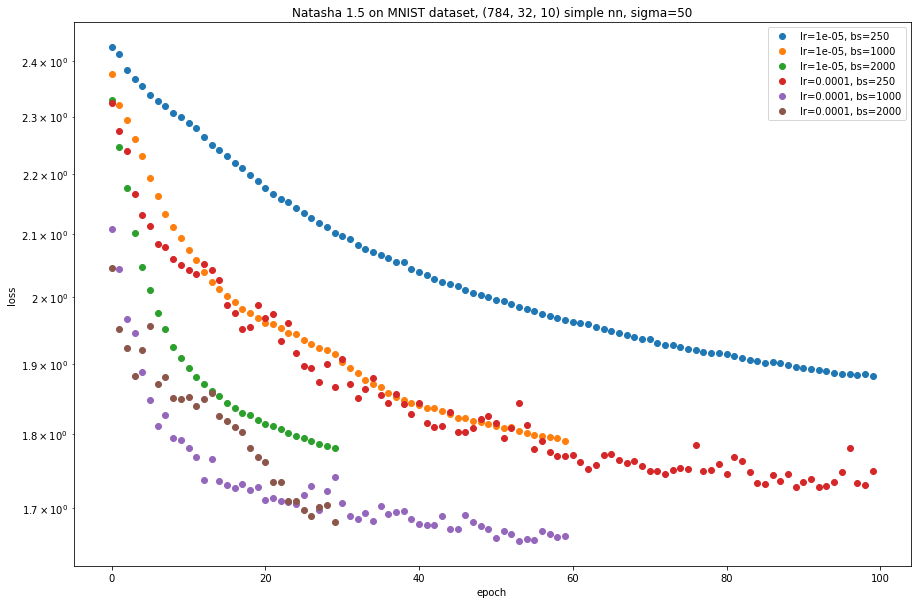

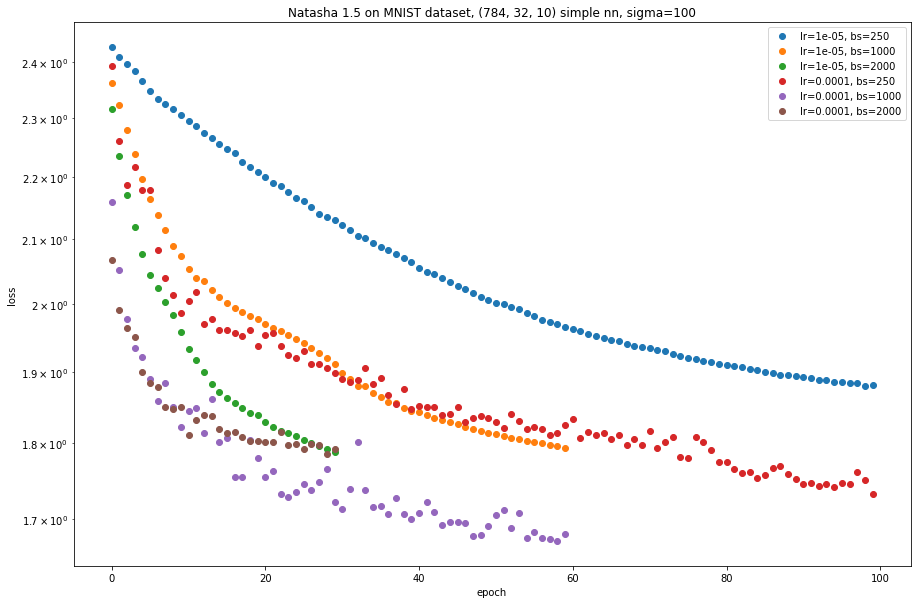

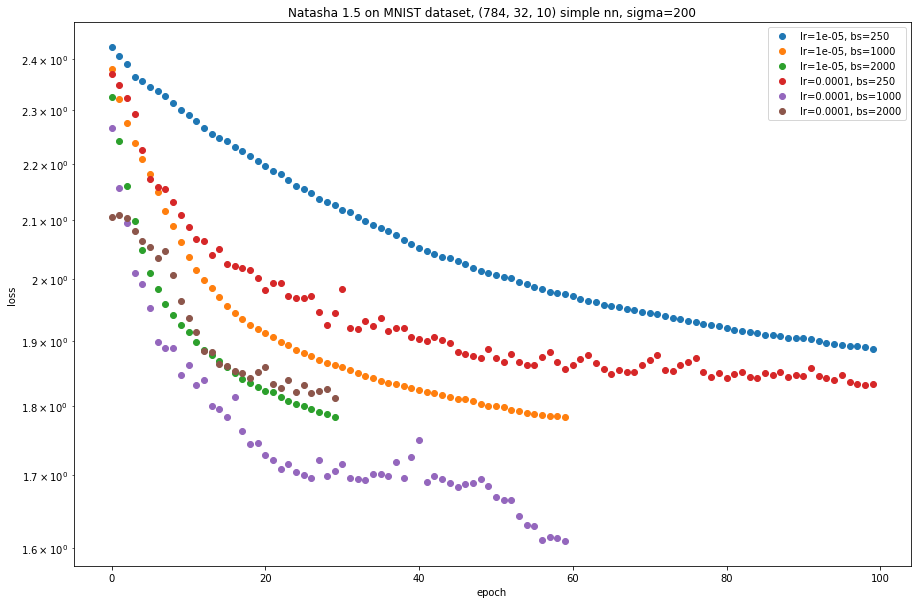

In [20]:
for s in Sigmas:
    plt.figure(figsize = (15,10))
    plt.title("Natasha 1.5 on MNIST dataset, (784, 32, 10) simple nn, sigma="+str(s))
    for lr, bs in product(LR,BS):
        plt.plot(n15_losses[lr, bs, s], 'o', label="lr="+str(lr)+", bs="+str(bs))
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.semilogy()


In [0]:
LR = [1e-5, 1e-4, 1e-3]
BS = [250, 1000, 2000]
Ls = [0.1, 10, 1000]
L_2s = [0.1, 10, 1000]

n_epochs = 50

n2_models = dict()
n2_losses = dict()

In [0]:
for lr, bs, L, L_2 in product(LR, BS, Ls, L_2s):
    n2_models[(lr, bs, L, L_2)] = copy.deepcopy(model).cuda()

In [0]:
for lr, bs, L, L_2 in product(LR, BS, Ls, L_2s):
    n2_losses[(lr, bs, L, L_2)] = natasha_2(train_dataset, bs, n2_models[(lr, bs, L, L_2)],loss, None, lr, n_epochs, L = L, L_2 = L_2)

In [0]:
for L, L_2 in profuct(Ls, L_2s):
    lt.figure(figsize = (15,10))
    plt.title("Natasha 2 on MNIST dataset, (784, 32, 10) simple nn, L="+str(L)+r"$L_2=$"+str(L_2))
    for lr, bs in product(LR,BS):
        plt.plot(n2_losses[lr, bs, L, L_2], 'o', label="lr="+str(lr)+", bs="+str(bs))
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.semilogy()

    